### Import Data

The dataset is publiclly available, and you can download it here: https://botometer.osome.iu.edu/bot-repository/datasets/caverlee-2011/caverlee-2011.zip

NOTE: You must download the dataset and extract it in your repo here in order to run the features. If you just want to run the model using the data extracted, you can skip to the "Building the Model" section.

In [1]:
# paths
ROOT_DIR = "caverlee-2011/social_honeypot_icwsm_2011/"

In [2]:
# read data
import pandas as pd

ham_users = pd.read_csv(ROOT_DIR + "legitimate_users.txt",
                         sep='\t',
                         names = ['UserID',
                                  'CreatedAt',
                                  'CollectedAt',
                                  'NumberOfFollowings',
                                  'NumberOfFollowers',
                                  'NumberOfTweets',
                                  'LengthOfScreenName',
                                  'LengthOfDescriptionInUserProfile'])
ham_tweets = pd.read_csv(ROOT_DIR + "legitimate_users_tweets.txt",
                                       sep='\t',
                                       names = ['UserID',
                                                'TweetID',
                                                'Tweet',
                                                'CreatedAt'])

ham_followings = pd.read_csv(ROOT_DIR + "legitimate_users_followings.txt",
                                       sep='\t',
                                       names = ['UserID',
                                                'SeriesOfNumberOfFollowings'])


spam_users = pd.read_csv(ROOT_DIR + "content_polluters.txt",
                         sep='\t',
                         names = ['UserID',
                                  'CreatedAt',
                                  'CollectedAt',
                                  'NumberOfFollowings',
                                  'NumberOfFollowers',
                                  'NumberOfTweets',
                                  'LengthOfScreenName',
                                  'LengthOfDescriptionInUserProfile'])
spam_tweets = pd.read_csv(ROOT_DIR + "content_polluters_tweets.txt",
                                       sep='\t',
                                       names = ['UserID',
                                                'TweetID',
                                                'Tweet',
                                                'CreatedAt'])
spam_followings = pd.read_csv(ROOT_DIR + "content_polluters_followings.txt",
                                       sep='\t',
                                       names = ['UserID',
                                                'SeriesOfNumberOfFollowings'])
       

In [3]:
print("Num of content polluters: " + str(len(spam_users)))
print("Num of content polluter's tweets: " + str(len(spam_tweets)))
print("Num of legitimate users: " + str(len(ham_users)))
print("Num of legitimate user's tweets: " + str(len(ham_tweets)))

Num of content polluters: 22223
Num of content polluter's tweets: 2333691
Num of legitimate users: 19276
Num of legitimate user's tweets: 3246377


### Feature Extraction

Features:

(User demographics)
1. Length of Screen Name (given)
2. Length of Description (given)
3. Longevity (calculate)

(User Friendship Networks)
1. Number of following (given)
2. Number of followers (given)
3. Ratio of Number of following and followers (calculate)
4. Percentage of Bidirectional Friends (missing)
5. Standard Deviation of Unique numerical IDs of following (missing)
6. standard deviation of unique numerical IDs of followers (missing)

(User Content)
1. the number of posted tweets (given)
2. number of posted tweets per day (calculate)
3. |links|in tweets /|tweets| (calculate)
4. |unique links|in tweets /|tweets| (calculate)
5. |@username|in tweets /|tweets| (calculate)
6. |unique@username|in tweets /|tweets| (calculate)
7. Average Content Similarity over all pairs of tweets posted by a user (calculate, don't know similarity metric- will use jaccard)
8. ZIP compression ratio of posted tweets (calculate)

(User History)
1. Change rate of number of following (calculate)

#### Given Features
Length of Screen Name, Length of User Profile Description, Number of Following, Number of Followers, Number of Tweets

In [4]:
import numpy as np
# given features
ham_users_input = ham_users[['UserID',
                             'LengthOfScreenName',
                            'LengthOfDescriptionInUserProfile',
                           'NumberOfFollowings',
                           'NumberOfFollowers',
                           'NumberOfTweets']]

spam_users_input = spam_users[['UserID',
                             'LengthOfScreenName',
                            'LengthOfDescriptionInUserProfile',
                           'NumberOfFollowings',
                           'NumberOfFollowers',
                           'NumberOfTweets']]

Extract number of Tweets recorded in the database per user. This will come in handy for calculations later down the line.

In [5]:
# get tweet counts by user
ham_tweet_counts = ham_tweets.groupby('UserID').size().reset_index()
ham_tweet_counts.columns = ['UserID','RecordedTweetCount']
ham_users = pd.merge(ham_users, ham_tweet_counts, on='UserID', how='left')

spam_tweet_counts = spam_tweets.groupby('UserID').size().reset_index()
spam_tweet_counts.columns = ['UserID','RecordedTweetCount']
spam_users = pd.merge(spam_users, spam_tweet_counts, on='UserID', how='left')

#### Longevity

In [6]:
# add longevity
from datetime import datetime
date_format = '%Y-%m-%d %H:%M:%S'

def get_longevity(start,end):
    start_date = datetime.strptime(start, date_format)
    end_date = datetime.strptime(end, date_format)
    return (end_date - start_date).days

ham_users_input['Longevity'] = ham_users.apply(lambda row: get_longevity(row['CreatedAt'],row['CollectedAt']), axis=1)

spam_users_input['Longevity'] = spam_users.apply(lambda row: get_longevity(row['CreatedAt'],row['CollectedAt']), axis=1)

#### Ratio of Following to Followers

In [7]:
# add ratio of followings to followers
ham_users_input['FollowRatio'] = ham_users_input['NumberOfFollowings'] / ham_users_input['NumberOfFollowers']
# replace divide by zero errors with 0
ham_users_input['FollowRatio'] = ham_users_input['FollowRatio'].replace([np.inf, -np.inf], np.nan).fillna(0)

# add ratio of followings to followers
spam_users_input['FollowRatio'] = spam_users_input['NumberOfFollowings'] / spam_users_input['NumberOfFollowers']
# replace divide by zero errors with 0
spam_users_input['FollowRatio'] = spam_users_input['FollowRatio'].replace([np.inf, -np.inf], np.nan).fillna(0)

#### Tweets Posted Per Day

In [8]:
# add number of posted tweets per day
ham_users_input['TweetsPerDay'] = ham_users_input['NumberOfTweets'] / ham_users_input['Longevity']
# replace divide by zero errors with 0
ham_users_input['TweetsPerDay'] = ham_users_input['TweetsPerDay'].replace([np.inf, -np.inf], np.nan).fillna(0)

# add number of posted tweets per day
spam_users_input['TweetsPerDay'] = spam_users_input['NumberOfTweets'] / spam_users_input['Longevity']
# replace divide by zero errors with 0
spam_users_input['TweetsPerDay'] = spam_users_input['TweetsPerDay'].replace([np.inf, -np.inf], np.nan).fillna(0)

#### Average Links Per Tweet

In [9]:
# add average links per tweet
import re

# function for counting number of links in tweet
def count_links(text):
    return len(re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', str(text)))

# add link count to tweets dataframe
ham_tweets['LinkCount'] = ham_tweets['Tweet'].apply(lambda x: count_links(x))
# get sum of links by user
ham_sum_links = ham_tweets.groupby('UserID')['LinkCount'].sum().reset_index()
ham_sum_links.columns = ['UserID','LinkSum']
# add link average to features
ham_users_input['LinkAverage'] = ham_sum_links['LinkSum'] / ham_users['RecordedTweetCount']
# replace divide by zero errors with 0
ham_users_input['LinkAverage'] = ham_users_input['LinkAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

# add link count to tweets dataframe
spam_tweets['LinkCount'] = spam_tweets['Tweet'].apply(lambda x: count_links(x))
# get sum of links by user
spam_sum_links = spam_tweets.groupby('UserID')['LinkCount'].sum().reset_index()
spam_sum_links.columns = ['UserID','LinkSum']
# add link average to features
spam_users_input['LinkAverage'] = spam_sum_links['LinkSum'] / spam_users['RecordedTweetCount']
# replace divide by zero errors with 0
spam_users_input['LinkAverage'] = spam_users_input['LinkAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

#### Average Unique Links Per Tweet

In [10]:
# add average unique links per tweet

# function for finding links in tweet
def get_links(text):
    return set(re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', str(text)))

# function for merging sets
def merge_sets(sets):
    return set.union(*sets)

# add unique links to tweets dataframe
ham_tweets['UniqueLinks'] = ham_tweets['Tweet'].apply(lambda x: get_links(x))
# get unique links by user
ham_unique_links = ham_tweets.groupby('UserID')['UniqueLinks'].agg(merge_sets).reset_index()
ham_unique_links.columns = ['UserID','UniqueLinks']
ham_unique_links['UniqueLinkSum'] = ham_unique_links['UniqueLinks'].apply(lambda x: len(x))
# add unique link average to features
ham_users_input['UniqueLinkAverage'] = ham_unique_links['UniqueLinkSum'] / ham_users['RecordedTweetCount']
# replace divide by zero errors with 0
ham_users_input['UniqueLinkAverage'] = ham_users_input['UniqueLinkAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

# add unique links to tweets dataframe
spam_tweets['UniqueLinks'] = spam_tweets['Tweet'].apply(lambda x: get_links(x))
# get unique links by user
spam_unique_links = spam_tweets.groupby('UserID')['UniqueLinks'].agg(merge_sets).reset_index()
spam_unique_links.columns = ['UserID','UniqueLinks']
spam_unique_links['UniqueLinkSum'] = spam_unique_links['UniqueLinks'].apply(lambda x: len(x))
# add unique link average to features
spam_users_input['UniqueLinkAverage'] = spam_unique_links['UniqueLinkSum'] / ham_users['RecordedTweetCount']
# replace divide by zero errors with 0
spam_users_input['UniqueLinkAverage'] = spam_users_input['UniqueLinkAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

#### Average Mentions Per Tweet

In [11]:
# add average mentions per tweet

def count_mentions(text):
    return len(re.findall("@([a-zA-Z0-9]{1,15})", str(text)))

# add username count to tweets dataframe
ham_tweets['MentionCount'] = ham_tweets['Tweet'].apply(lambda x: count_mentions(x))
# get sum of mentions by user
ham_sum_mentions = ham_tweets.groupby('UserID')['MentionCount'].sum().reset_index()
ham_sum_mentions.columns = ['UserID','MentionSum']
# add mention average to features
ham_users_input['MentionAverage'] = ham_sum_mentions['MentionSum'] / ham_users['RecordedTweetCount']
# replace divide by zero errors with 0
ham_users_input['MentionAverage'] = ham_users_input['MentionAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

# add username count to tweets dataframe
spam_tweets['MentionCount'] = spam_tweets['Tweet'].apply(lambda x: count_mentions(x))
# get sum of mentions by user
spam_sum_mentions = spam_tweets.groupby('UserID')['MentionCount'].sum().reset_index()
spam_sum_mentions.columns = ['UserID','MentionSum']
# add mention average to features
spam_users_input['MentionAverage'] = spam_sum_mentions['MentionSum'] / spam_users['RecordedTweetCount']
# replace divide by zero errors with 0
spam_users_input['MentionAverage'] = spam_users_input['MentionAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

#### Average Unique Mentions Per Tweet

In [12]:
# add average unique mentions per tweet

# function for finding mentions in tweet
def get_mentions(text):
    return set(re.findall("@([a-zA-Z0-9]{1,15})", str(text)))

# add unique mentions to tweets dataframe
ham_tweets['UniqueMentions'] = ham_tweets['Tweet'].apply(lambda x: get_mentions(x))
# get unique mentions by user
ham_unique_mentions = ham_tweets.groupby('UserID')['UniqueMentions'].agg(merge_sets).reset_index()
ham_unique_mentions.columns = ['UserID','UniqueMentions']
ham_unique_mentions['UniqueMentionSum'] = ham_unique_mentions['UniqueMentions'].apply(lambda x: len(x))
# add unique mention average to features
ham_users_input['UniqueMentionAverage'] = ham_unique_mentions['UniqueMentionSum'] / ham_users['RecordedTweetCount']
# replace divide by zero errors with 0
ham_users_input['UniqueMentionAverage'] = ham_users_input['UniqueMentionAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

# add unique mentions to tweets dataframe
spam_tweets['UniqueMentions'] = spam_tweets['Tweet'].apply(lambda x: get_mentions(x))
# get unique mentions by user
spam_unique_mentions = spam_tweets.groupby('UserID')['UniqueMentions'].agg(merge_sets).reset_index()
spam_unique_mentions.columns = ['UserID','UniqueMentions']
spam_unique_mentions['UniqueMentionSum'] = spam_unique_mentions['UniqueMentions'].apply(lambda x: len(x))
# add unique mention average to features
spam_users_input['UniqueMentionAverage'] = spam_unique_mentions['UniqueMentionSum'] / spam_users['RecordedTweetCount']
# replace divide by zero errors with 0
spam_users_input['UniqueMentionAverage'] = spam_users_input['UniqueMentionAverage'].replace([np.inf, -np.inf], np.nan).fillna(0)

#### Average Similarity over all Tweets

In [13]:
# add average similarity score for every pairwise comparisons
import itertools

# similarity calculation
def jaccard(str1,str2): 
    # split words to sets
    set1 = set(str1.lower().split()) 
    set2 = set(str2.lower().split())
    # catch divide by 0
    if len(set1.union(set2)) == 0:
        return 1
    # calculate jaccard (intersection / union)
    return len(set1.intersection(set2)) / len(set1.union(set2))

# store ham jaccard scores
ham_jaccard_scores = []

ham_unique_ids = ham_tweets['UserID'].unique()
count = 0
for user in ham_unique_ids:
    # get all tweets for user
    x = list(ham_tweets.loc[ham_tweets['UserID'] == user]['Tweet'])
    
    if (len(x) > 1):
        combos = list(itertools.combinations(x, 2))
        # get average jaccard score over all pairs
        sim_scores = [jaccard(str(pair[0]),str(pair[1])) for pair in combos]
        avg_score = sum(sim_scores) / len(combos)
        # record similarity score
        ham_jaccard_scores.append(avg_score)
    else:
        ham_jaccard_scores.append(1)
    # progress
    count +=1
    if count % 1000 == 0:
        print(str(count) + " / " + str(len(ham_unique_ids)))

# create dataframe of ids and scores
ham_jaccard_dict = {'UserID' : ham_unique_ids, 'Similarity' : ham_jaccard_scores}
ham_jaccard_df = pd.DataFrame.from_dict(ham_jaccard_dict)

# add to features
ham_users_input = pd.merge(ham_users_input, ham_jaccard_df[['UserID','Similarity']], on='UserID', how='left')
# give users with no tweets similarity of 1
ham_users_input['Similarity'] = ham_users_input['Similarity'].fillna(1)

1000 / 19251
2000 / 19251
3000 / 19251
4000 / 19251
5000 / 19251
6000 / 19251
7000 / 19251
8000 / 19251
9000 / 19251
10000 / 19251
11000 / 19251
12000 / 19251
13000 / 19251
14000 / 19251
15000 / 19251
16000 / 19251
17000 / 19251
18000 / 19251
19000 / 19251


In [14]:
# store spam jaccard scores
spam_jaccard_scores = []

spam_unique_ids = spam_tweets['UserID'].unique()
count = 0
for user in spam_unique_ids:
    # get all tweets for user
    x = list(spam_tweets.loc[spam_tweets['UserID'] == user]['Tweet'])
    
    if (len(x) > 1):
        combos = list(itertools.combinations(x, 2))
        # get average jaccard score over all pairs
        sim_scores = [jaccard(str(pair[0]),str(pair[1])) for pair in combos]
        avg_score = sum(sim_scores) / len(combos)
        # record similarity score
        spam_jaccard_scores.append(avg_score)
    else:
        spam_jaccard_scores.append(1)
    # progress
    count +=1
    if count % 1000 == 0:
        print(str(count) + " / " + str(len(spam_unique_ids)))

# create dataframe of ids and scores
spam_jaccard_dict = {'UserID' : spam_unique_ids, 'Similarity' : spam_jaccard_scores}
spam_jaccard_df = pd.DataFrame.from_dict(spam_jaccard_dict)

# add to features
spam_users_input = pd.merge(spam_users_input, spam_jaccard_df[['UserID','Similarity']], on='UserID', how='left')
# give users with no tweets similarity of 1
spam_users_input['Similarity'] = spam_users_input['Similarity'].fillna(1)

1000 / 20645
2000 / 20645
3000 / 20645
4000 / 20645
5000 / 20645
6000 / 20645
7000 / 20645
8000 / 20645
9000 / 20645
10000 / 20645
11000 / 20645
12000 / 20645
13000 / 20645
14000 / 20645
15000 / 20645
16000 / 20645
17000 / 20645
18000 / 20645
19000 / 20645
20000 / 20645


#### Zip Compression Ratio

In [15]:
# add zip compression ratio

import zlib

# get compression ratio of tweets
def get_compression_ratio(text):
    data=text.encode('utf-8')
    compressed_data = zlib.compress(data)
    return len(data)/len(compressed_data)

# concatenate tweets by user
ham_concat_tweets = ham_tweets.groupby('UserID')['Tweet'].agg(lambda x: ' '.join(str(x))).reset_index()
ham_concat_tweets.columns = ['UserID','Concat_Tweets']
# calculate compression ratio from concatenated tweets
ham_concat_tweets['Compression_Ratio'] = ham_concat_tweets['Concat_Tweets'].apply(lambda x: get_compression_ratio(x))
# add to features
ham_users_input = pd.merge(ham_users_input, ham_concat_tweets[['UserID','Compression_Ratio']], on='UserID', how='left')
# give users with no tweets compression ratio of 0
ham_users_input['Compression_Ratio'] = ham_users_input['Compression_Ratio'].fillna(0)

# concatenate tweets by user
spam_concat_tweets = spam_tweets.groupby('UserID')['Tweet'].agg(lambda x: ' '.join(str(x))).reset_index()
spam_concat_tweets.columns = ['UserID','Concat_Tweets']
# calculate compression ratio from concatenated tweets
spam_concat_tweets['Compression_Ratio'] = spam_concat_tweets['Concat_Tweets'].apply(lambda x: get_compression_ratio(x))
# add to features
spam_users_input = pd.merge(spam_users_input, spam_concat_tweets[['UserID','Compression_Ratio']], on='UserID', how='left')
# give users with no tweets compression ratio of 0
spam_users_input['Compression_Ratio'] = spam_users_input['Compression_Ratio'].fillna(0)

#### Following Change Rate

In [16]:
# add following change rate
import math

# calculate change rate based on sequence string
def calculate_change_rate(seq_str):
    seq = [int(x) for x in seq_str.split(",")]
    n = len(seq)
    # perform summation
    total =0
    for i in range(0,n-1):
        total += abs(seq[i+1] - seq[i])
#     return total/(n-1)
    return math.sqrt(total/(n-1))

# calculate following change rate by user
ham_followings['FollowingChangeRate'] = ham_followings['SeriesOfNumberOfFollowings'].apply(lambda x: calculate_change_rate(x))
# add to features
ham_users_input = pd.merge(ham_users_input, ham_followings[['UserID','FollowingChangeRate']], on='UserID', how='left')
# fill in zeroes
ham_users_input['FollowingChangeRate'] = ham_users_input['FollowingChangeRate'].fillna(0)

# calculate following change rate by user
spam_followings['FollowingChangeRate'] = spam_followings['SeriesOfNumberOfFollowings'].apply(lambda x: calculate_change_rate(x))
# add to features
spam_users_input = pd.merge(spam_users_input, spam_followings[['UserID','FollowingChangeRate']], on='UserID', how='left')
# fill in zeroes
spam_users_input['FollowingChangeRate'] = spam_users_input['FollowingChangeRate'].fillna(0)

### Save Dataset

In [17]:
# save dataset
ham_users_input.to_csv('data/ham_features.csv', index = False)
spam_users_input.to_csv('data/spam_features.csv', index = False)

### Data Preparation

In [18]:
# load dataset
import pandas as pd
ham_users_input = pd.read_csv('data/ham_features.csv')
spam_users_input = pd.read_csv('data/spam_features.csv')

In [19]:
# add labels
ham_users_input['label'] = "Legit"
spam_users_input['label'] = "Polluter"

In [20]:
# combine dataframes
df = pd.concat([ham_users_input,spam_users_input])

### Analyze Change Rate of Following

According to the previous study from 2011, "Change Rate of Following" was the second most important feature in the dataset and the best feature we could extract. We will see how well the feature differentiates content polluters from legitimate users.

In [21]:
df = df.sample(frac=0.1, random_state=1)

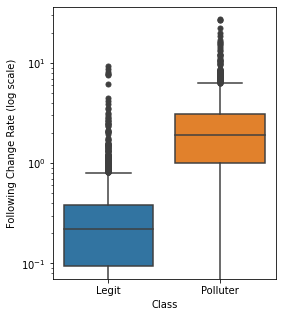

In [22]:
import matplotlib.pyplot as plt
import seaborn as sn

# boxplot
plt.figure(figsize = (4,5))
sn.boxplot( x=df["label"], y=df["FollowingChangeRate"], orient="v", flierprops={"marker": "o"},)
plt.xlabel('Class')
plt.ylabel('Following Change Rate (log scale)')
# plt.title('Following Change Rate')
plt.yscale('log')

# Show the plot
plt.show()

# Building the Model

### Load Features

In [23]:
# load dataset
import pandas as pd
ham_users_input = pd.read_csv('data/ham_features.csv')
spam_users_input = pd.read_csv('data/spam_features.csv')

### Data Preparation

In [24]:
# add labels
ham_users_input['label'] = 0 
spam_users_input['label'] = 1

In [25]:
# combine dataframes
df = pd.concat([ham_users_input,spam_users_input])
# drop userID
df.drop(['UserID'], axis=1, inplace=True)

In [26]:
# separate features from labels
X = df.drop('label', axis = 1)
y = df['label']

In [27]:
# split train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Training Classifier

### Evaluating Classifer

### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
import datetime

param_grid = { 
    'max_depth': [None, 5, 10, 25, 50, 100],
    'n_estimators': [50, 100, 200, 300, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_samples': [0.2, 0.5, 1],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

print(f"START TIME: {datetime.datetime.now()}")
print("Beginning Grid Search for Hyperparameter Tuning.")
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid,
                           scoring='accuracy',
                           verbose=1,
                           n_jobs=-1) 
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(f"Success!\nEND TIME: {datetime.datetime.now()}")

### Training Final Model after Tuning

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# train RF
clf = RandomForestClassifier(random_state= 26, max_depth = 25, max_features = 'sqrt', max_samples = 0.5, n_estimators=200)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, max_features='sqrt', max_samples=0.5,
                       n_estimators=200, random_state=26)

In [29]:
# predict on test set
y_pred = clf.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.5f}')
f1 = f1_score(y_test, y_pred)
print(f'F1-Score: {f1:.5f}')

Accuracy: 0.95867
F1-Score: 0.96179


In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

Text(24.0, 0.5, 'True')

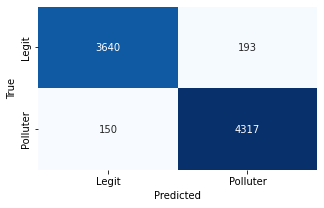

In [31]:
import seaborn as sn
import matplotlib.pyplot as plt
classes = ["Legit","Polluter"]
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')